# Earth2MIP Demo - Custom Datasets

**Installation**

* [apex](https://github.com/NVIDIA/apex#quick-start)

In [1]:
import numpy as np
import cdsapi
from pathlib import Path
import xarray as xr
import autoroot
import datetime
from earth2mip import inference_ensemble, registry
from earth2mip.networks import get_model
from earth2mip.initial_conditions import cds
from earth2mip.inference_ensemble import run_basic_inference, run_inference, get_initializer
import matplotlib.pyplot as plt
from bayesevt._src.data.ics import LocalDataSourceXArray
from earth2mip.schema import EnsembleRun
import json
import torch
import seaborn as sns
import cartopy.crs as ccrs
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Model

First, we need to select a model.
This will depend on what you choose to install. 
I personally chose the `FourCastNet` model because it is the most flexible in terms of resolution (in theory). 
But in principal, we could choose other models but it would depend on the variables.

In [2]:
model_name = "fcnv2_sm" 
device = "cuda:1"

In [3]:

model = get_model(model_name, device=device)

channel_names = model.channel_names

***

## Initial Condition

We need to do an initial condition to propagate the data forward.
We will use a special `dataclass` which defines all of the parameters we need to load data from an `xarray.Dataset`.
This should include `.netcdf`, `.grib`, and `.grib`. 
As long as we can define the xarray engine and it follows some standards, we should be able to load it.

**Parameters**

* `t0` - `datetime` object with a time period.
* `num_steps` - the number of time steps (6h intervals)

In [4]:
# local dataset
save_name = "reanalysis_20180715_20180830_ics_v2"

file_paths = [
    f"/pool/proyectos/CLINT/sa4attrs/data/raw/events/{save_name}.nc"
]

In [5]:
# initial condition
data_source_xr = LocalDataSourceXArray(
    channel_names=channel_names,
    file_paths=file_paths,
    pressure_name="level", 
    name_convention="era5_name",
    engine="netcdf4", 
    
)

## Inference Loop

In [6]:
ensemble_members: int = 30

noise_amplitiude: int = 0.05

simulation_length: int = 4 * 10 # (6hrs x 4) days x 10

t0 = "2018-07-31 00:00:00"
t0_save_name = t0.split(" ")[0].replace("-","")

output_path = f"/pool/proyectos/CLINT/sa4attrs/data/pred/earth2mip/{model_name}_{t0_save_name}_ens{ensemble_members}"
output_path

'/pool/proyectos/CLINT/sa4attrs/data/pred/earth2mip/fcnv2_sm_20180731_ens30'

In [7]:
config_dict = {
    "ensemble_members": ensemble_members,
    "noise_amplitude": noise_amplitiude,
    "simulation_length": simulation_length,
    "weather_event": {
        "properties": {
            "name": "Globe",
            "start_time": t0,
            "initial_condition_source": "cds",
        },
        "domains": [
            {
                "name": "global",
                "type": "Window",
                "diagnostics": [{"type": "raw", "channels": ["t2m", "u10m"]}],
            }
        ],
    },
    "output_path": output_path,
    "output_frequency": 1,
    "weather_model": model_name,
    "seed": 12345,
    "use_cuda_graphs": False,
    "ensemble_batch_size": 1,
    "autocast_fp16": False,
    "perturbation_strategy": "correlated",
    "noise_reddening": 2.0,
}


In [8]:
config = EnsembleRun.parse_obj(config_dict)
# get group
group = torch.distributed.group.WORLD
# get perturbation strategy
perturb = get_initializer(model, config)

In [9]:
%%time

# run inference loop
run_inference(
    model=model, 
    config=config, 
    perturb=perturb, 
    group=group, 
    data_source=data_source_xr
)

CPU times: user 11min 37s, sys: 12min 36s, total: 24min 14s
Wall time: 12min 15s


#### Opening File

It's not straightforward to open the file because they use a nested saving pattern.
We need to manually add the `group` option when we load the data.

In [9]:
from bayesevt._src.data.netcdf import load_ensemble_dataset

In [10]:
domain = config_dict["weather_event"]["domains"][0]["name"]
output_path_name = Path(output_path).joinpath("ensemble_out_0.nc")

ds = load_ensemble_dataset(output_path_name, domain=domain)

In [11]:
ds

<xarray.Dataset> Size: 20GB
Dimensions:  (lat: 721, lon: 1440, ensemble: 30, time: 41)
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 328B 2018-07-31 ... 2018-08-10
Dimensions without coordinates: ensemble
Data variables:
    imin     int64 8B ...
    imax     int64 8B ...
    jmin     int64 8B ...
    jmax     int64 8B ...
    t2m      (ensemble, time, lat, lon) float64 10GB dask.array<chunksize=(10, 1, 241, 480), meta=np.ndarray>
    u10m     (ensemble, time, lat, lon) float64 10GB dask.array<chunksize=(10, 1, 241, 480), meta=np.ndarray>
Attributes:
    model:          fcnv2_sm
    config:         {"weather_model": "fcnv2_sm", "simulation_length": 40, "p...
    weather_event:  {"properties": {"name": "Globe", "start_time": "2018-07-3...
    date_created:   2024-02-25T17:22:58.237373
    history:        /home/juanjohn/miniconda/envs/bayesevt_ai/lib/python3.10/...
    institution:    NVIDIA
    Conventions:    CF-1.10

## Subset

In [12]:
from bayesevt._src.geoprocessing.masks import add_country_mask, add_land_mask

In [13]:
ds_subset = ds.t2m - 272.15
ds_subset = add_country_mask(ds_subset)
ds_subset["lon"] =  (ds_subset.lon + 180) % 360 - 180
ds_subset = ds_subset.sortby("lat").sortby("lon")
ds_subset = ds_subset.where(ds_subset["spain_mask"]==1, drop=True)

## Visualization

### Ensemble Members

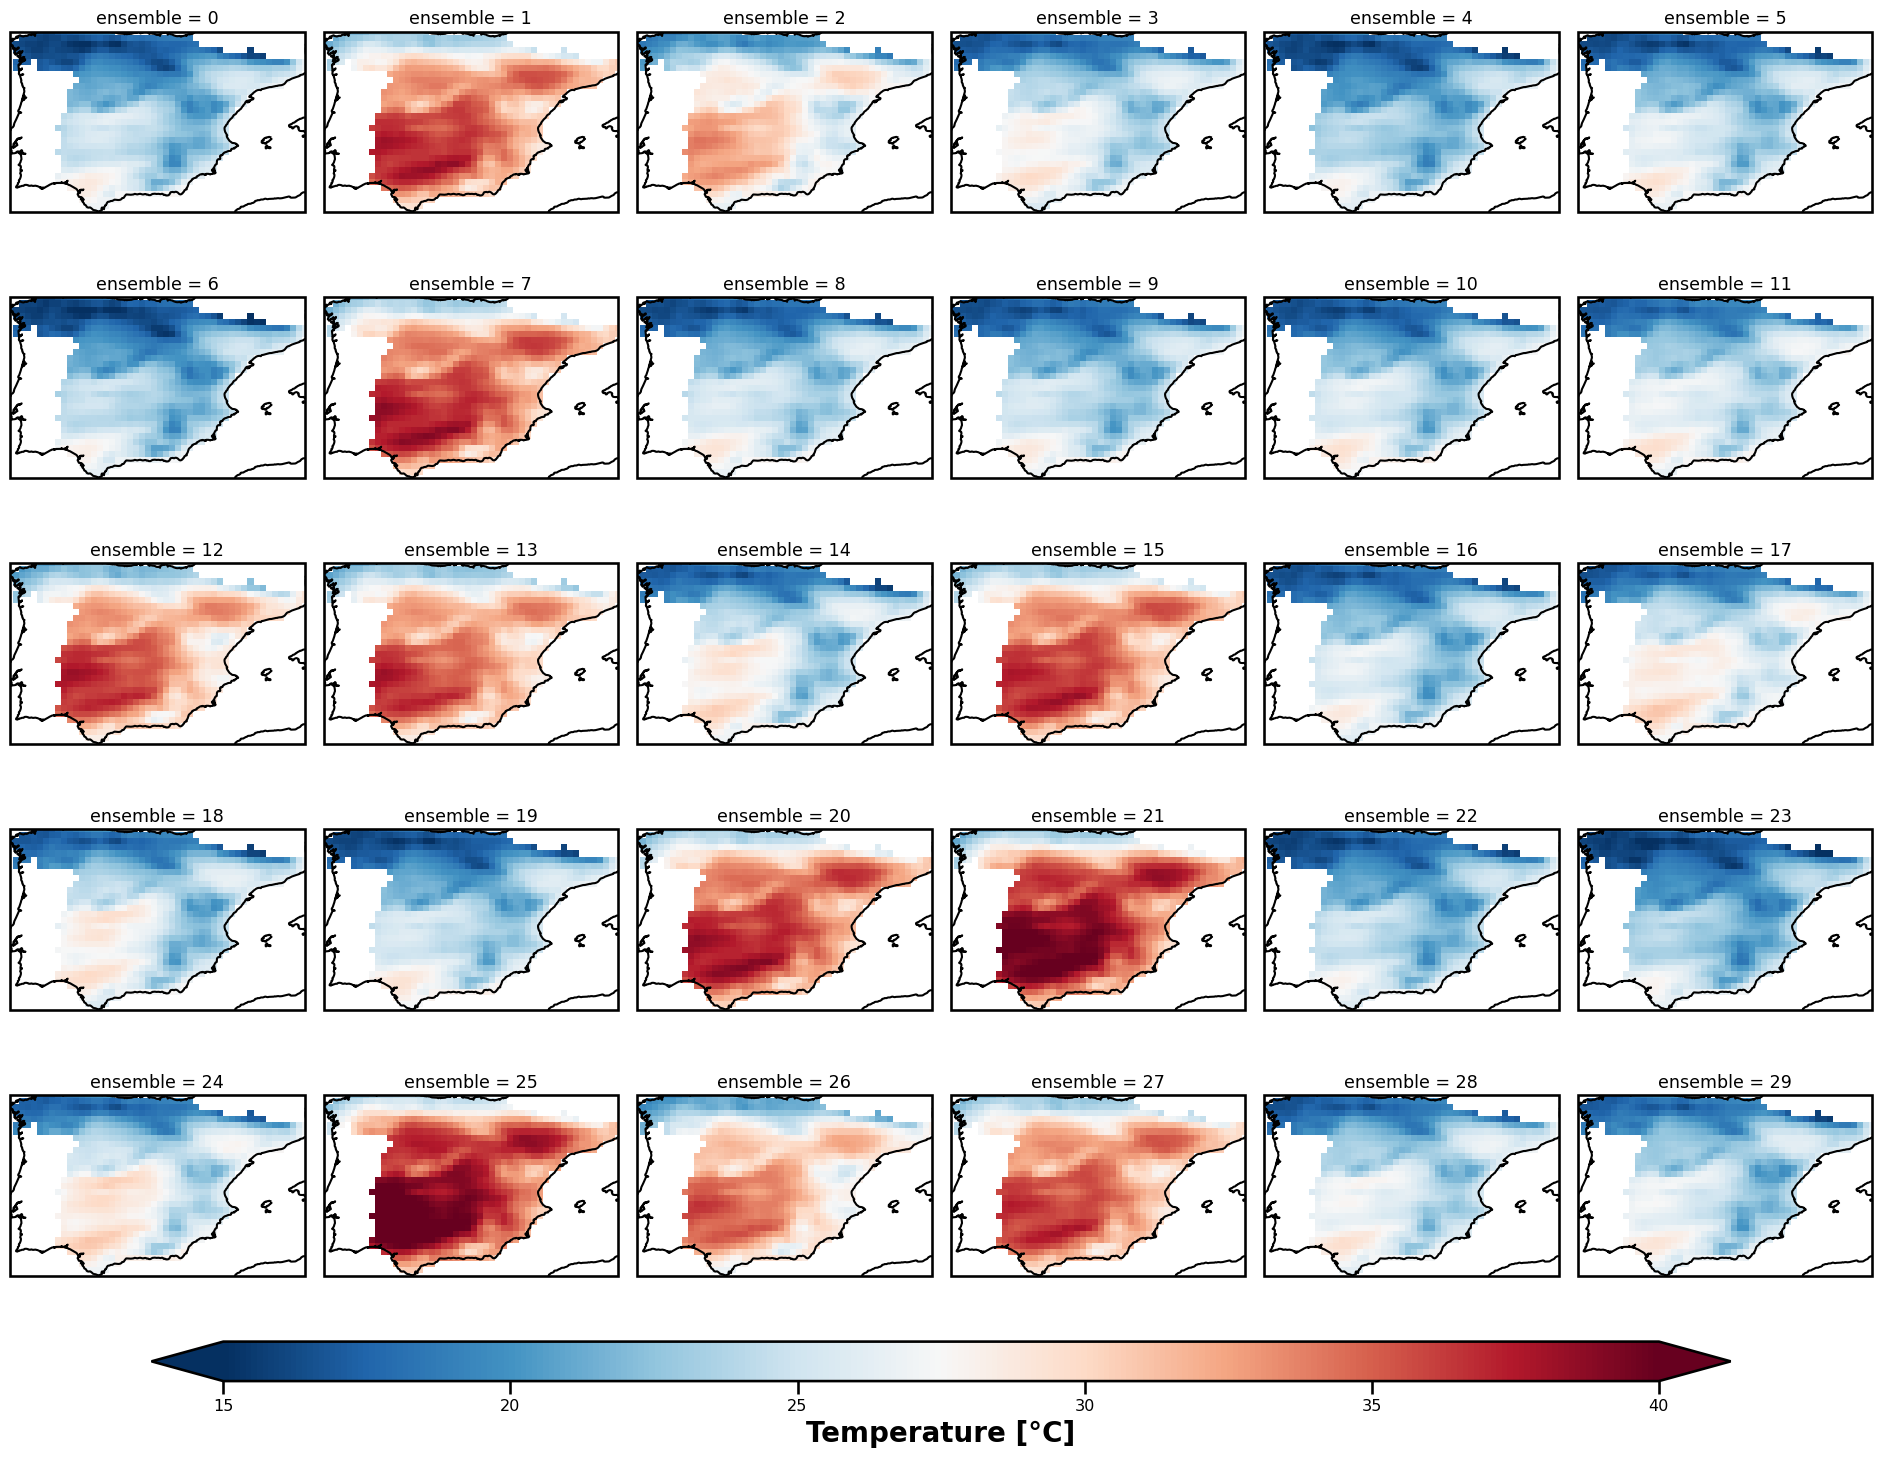

In [14]:
fig = ds_subset.isel(time=5).plot.pcolormesh(
    col="ensemble", col_wrap=6, cmap="RdBu_r",
    vmin=15, vmax=40,
    transform=ccrs.PlateCarree(),
    subplot_kws={
        "projection": ccrs.PlateCarree(),
        "xlim":[ds_subset.lon.values.min(), ds_subset.lon.values.max()],
        "ylim": [ds_subset.lat.values.min(), ds_subset.lat.values.max()],
    },
    # usual xarray stuff
    cbar_kwargs={
        "orientation": "horizontal", 
        # "shrink": 0.8, "aspect": 40, 
        "fraction": 0.027, "pad": 0.045, "aspect": 40,
    },
    robust=False,
)
fig.map(lambda: plt.gca().coastlines())
fig.cbar.set_label(label=f'Temperature [°C]', size=20, weight='bold')
# plt.tight_layout()
plt.show()

### Time Series

In [15]:
ds_mean_ts = ds_subset.mean(["lat", "lon", "ensemble"]).squeeze()
ds_stddev_ts = ds_subset.std(["lat", "lon", "ensemble"]).squeeze()

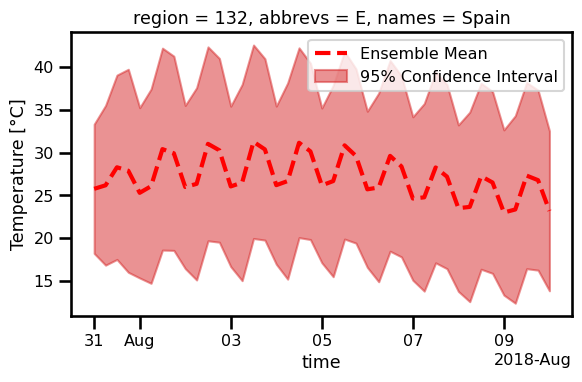

In [16]:
# plot
fig, ax = plt.subplots(figsize=(6,4))

ds_mean_ts.plot(ax=ax, label="Ensemble Mean", linestyle="--", linewidth=3, color="red")

# error bars
ax.fill_between(
    ds_mean_ts.time,
    ds_mean_ts.values + 1.96 * ds_stddev_ts.values,
    ds_mean_ts.values - 1.96 * ds_stddev_ts.values,
    alpha=0.5,
    color="tab:red",
    label="95% Confidence Interval",
)
ax.set(
    # ylim=[17, 35],
    ylabel="Temperature [°C]"
)


plt.tight_layout()
plt.legend()
plt.show()

#### Madrid

In [17]:
# select MADRID region
ds_mean_ts = ds_subset.sel(lon=-3.703790, lat=40.416775, method="nearest").mean(["ensemble"]).squeeze()
ds_stddev_ts = ds_subset.sel(lon=-3.703790, lat=40.416775, method="nearest").std(["ensemble"]).squeeze()

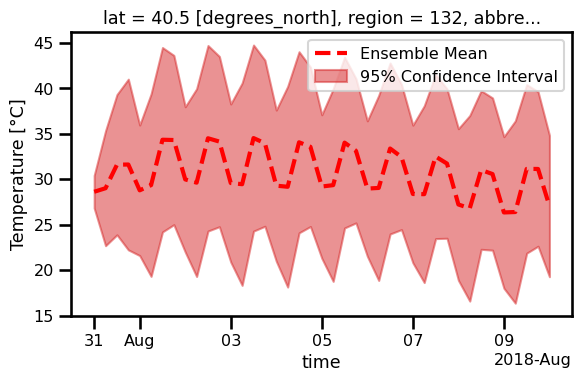

In [18]:
# plot
fig, ax = plt.subplots(figsize=(6,4))

ds_mean_ts.plot(ax=ax, label="Ensemble Mean", linestyle="--", linewidth=3, color="red")

# error bars
ax.fill_between(
    ds_mean_ts.time,
    ds_mean_ts.values + 1.96 * ds_stddev_ts.values,
    ds_mean_ts.values - 1.96 * ds_stddev_ts.values,
    alpha=0.5,
    color="tab:red",
    label="95% Confidence Interval",
)
ax.set(
    # ylim=[17, 35],
    ylabel="Temperature [°C]"
)


plt.tight_layout()
plt.legend()
plt.show()